

## Experiment Details
__Experiment Id__ : 006 \
__Target__ : Experiment model on MNIST dataset with random spaces \
__Solution__ : 
- create MNIST sticker set with random spaces
- train and test model on new dataset

__Empirical result__ : 
- 

---
Implementation

In [1]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses
from tcn import TCN

from tqdm import tqdm
import time
import math
import random 
import pandas as pd 
import numpy as np
from skimage import io, transform 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json

import tensorflow_datasets as tfds
import neptune.new as neptune

---
Set global variables

In [2]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE = (128,48)
DATA_BS = 10
DATA_N = 10
LR = 0.01
EPOCHS = 20
BS = 32
N_CLASSES = 11

---
Dataset & Dataloader

In [4]:
from PIL import Image
import matplotlib.pyplot as plt
from numpy import newaxis

In [5]:
(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'], with_info=True)
train_gen = tfds.as_numpy(ds_train)
test_gen = tfds.as_numpy(ds_test)

Load dataset info from ~\tensorflow_datasets\mnist\3.0.1
Field info.citation from disk and from code do not match. Keeping the one from code.
Field info.splits from disk and from code do not match. Keeping the one from code.
Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
Field info.module_name from disk and from code do not match. Keeping the one from code.
Reusing dataset mnist (~\tensorflow_datasets\mnist\3.0.1)
Constructing tf.data.Dataset mnist for split ['train', 'test'], from ~\tensorflow_datasets\mnist\3.0.1


In [6]:
class MNISTDataset(object):

    def __init__(self, n_digits=8, image_size=(156, 32)):
        self.n_digits = n_digits
        self.image_size = image_size

    def gen_data(self, gen):
        images, labels = [], []
        for x in gen:
            images.append(x['image'])
            labels.append(x['label'])
        self.pt_size = x['image'].shape[0]
        images, labels = np.squeeze(np.array(images)), np.squeeze(np.array(labels))#; print(images.shape,labels.shape,labels)
        return images, labels

    def gen_patch(self, img, ann, c=np.inf):
        size = img.shape[0]
        indexes = np.arange(size)
        np.random.shuffle(indexes)
        
        c_prime = divmod(size, self.n_digits)[0]*self.n_digits
        if c_prime < c:
            size = c_prime
        else:
            size = divmod(c, self.n_digits)[0]*self.n_digits

        sample_index = indexes[:size]
        sticker_index = sample_index.reshape((-1, self.n_digits)).T
        sticker_images = np.transpose(np.hstack([np.transpose(img[inds], (0, 2, 1)) for inds in sticker_index]), (0, 2, 1))
        sfl_label =  ann[sample_index, ...]
        sticker_labels = sfl_label.reshape((-1, self.n_digits))
        return sticker_images, sticker_labels

    def add_spaces(self, img, ann, n=1000):
        # print(img.shape, ann.shape)
        image_pt = np.zeros((n, self.pt_size, self.pt_size))
        label_pt = np.ones((n,))*10
        all_images = np.concatenate([img, image_pt], axis=0)
        all_labels = np.concatenate([ann, label_pt], axis=0)
        # print(all_images.shape, all_labels.shape)
        return all_images, all_labels

    def generate(self, data_generator, n_sample):
        init_image, init_label = self.gen_data(data_generator)
        imgWspace, labelWspace = self.add_spaces(init_image, init_label)
        c = n_sample
        dt_images, dt_labels = self.gen_patch(imgWspace, labelWspace, c)
        while c > self.n_digits:
            c = n_sample - dt_images.shape[0]
            p_images, p_labels = self.gen_patch(imgWspace, labelWspace, c)
            dt_images, dt_labels = np.vstack((dt_images, p_images)), np.vstack((dt_labels, p_labels))

        ret_tensor = tf.convert_to_tensor(np.swapaxes(dt_images, 1, 2), dtype=tf.float32);print(dt_images.shape,dt_labels.shape)
        ind_tensor = tf.convert_to_tensor(dt_labels, dtype=tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((ret_tensor, ind_tensor))
        return dataset

In [7]:
mnist = MNISTDataset()

In [8]:
train_dataset = mnist.generate(train_gen, n_sample=12_000)
test_dataset = mnist.generate(test_gen, n_sample=2000)

(11993, 28, 224) (11993, 8)
(1993, 28, 224) (1993, 8)


(224, 28)
[10  5  7  7  5  3  5 10]


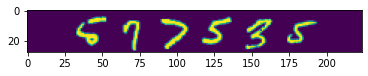

In [9]:
for i in test_dataset.take(1):
    img, label = i
print(img.shape)
print(label.numpy())
plt.imshow(img.numpy().T)
IMAGE_SIZE = img.shape

In [10]:
train_loader = train_dataset.shuffle(buffer_size=1000).batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

---
Model Defining

In [11]:
class mAP(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', alpha=0.9, **kwargs):
        super(mAP, self).__init__(name=name, **kwargs)
        self.map = self.add_weight(name='map', initializer='zeros')
        self.alpha = alpha

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        res_arr = tf.map_fn(lambda i: tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(y_true[i, ...], y_pred[i, ...])), elems=tf.range(y_pred.shape[0]), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.map), tf.multiply(alpha_prime, cur_val))
        self.map.assign(weighted_avg)

    def result(self):
        return self.map


In [12]:
class mDP(tf.keras.metrics.Metric):
    def __init__(self, name='mDP', n_classes=10, alpha=0.9, **kwargs):
        super(mDP, self).__init__(name=name, **kwargs)
        self.n = n_classes
        self.alpha = alpha
        self.mdp = self.add_weight(name='mdp', initializer='zeros')

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        def func(i):
            mask = tf.equal(y_true, tf.constant(i))
            ilabels = tf.reshape(tf.boolean_mask(y_true,mask), shape=(-1))
            ipreds = tf.reshape(tf.boolean_mask(y_pred,mask), shape=(-1, self.n))
            return tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(ilabels, ipreds))

        res_arr = tf.map_fn(lambda i: func(i), elems=tf.range(self.n), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.mdp), tf.multiply(alpha_prime, cur_val))
        self.mdp.assign(weighted_avg)

    def result(self):
        return self.mdp

In [13]:
class RecNet(tf.keras.Model):
	def __init__(self, bs=16, input_size=(128, 48), n_classes=10, h_cell=64, latent_size=32, max_obj=15, linear_k=3, rho=0.05):
		super().__init__()
		self.rho = rho
		self.bs = bs
		self.input_size = input_size
		self.n_classes = n_classes  # LSTM module projection size
		self.h_cell = h_cell  # LSTM hidden size
		self.latent_size = latent_size
		self.max_obj = max_obj
		self.linear_k = linear_k
		self.model = self.build_model(
			self.input_size, self.h_cell, self.latent_size, self.n_classes, self.max_obj, self.linear_k)

		self.scce = losses.SparseCategoricalCrossentropy(from_logits=False,)

		self.loss_metric = tf.keras.metrics.Mean(name="loss")
		self.acc_metric = tf.keras.metrics.Mean(name="accuracy")
		self.acc_mat = tf.keras.metrics.Accuracy()
		self.mAP = mAP()
		self.mDP = mDP(n_classes=self.n_classes)


	def build_model(self, input_shape=(128, 48), h_cell=32, latent_size=32, n_classes=10, n_obj=10, linear_k=3):
		x_input = layers.Input(shape=input_shape)
		forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
		x = layers.Bidirectional(forward_layer, input_shape=self.input_size)(x_input)
		x = layers.LSTM(latent_size, activation='tanh',
						return_sequences=True, go_backwards=True)(x)
		x = layers.Conv1D(n_classes, linear_k, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x = layers.Conv1D(n_obj, 1, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x_output = layers.Activation('softmax')(x)

		model = tf.keras.Model(inputs=x_input, outputs=x_output)
		return model

	@property
	def metrics(self):
		return [self.loss_metric, self.acc_mat]

	def calculate_loss(self, target, pred):
		target = tf.reshape(target, shape=(-1))
		pred = tf.reshape(pred, shape=(-1, self.n_classes))
		loss = self.scce(target, pred)

		y_hat = tf.argmax(pred, axis=-1)
		acc = self.acc_mat(y_hat, target)
		return loss, acc

	def call(self, x):
		full_out = self.model(x)
		return full_out

	def train_step(self, batch_data):
		x, target = batch_data
		e_ws = []
		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			# print(pred.shape, pred)
			loss, acc = self.calculate_loss(target, pred)

		trainable_params = self.trainable_variables
		gradients = tape.gradient(loss, trainable_params)
		grad_norm = self._grad_norm(gradients)
		scale = self.rho / (grad_norm + 1e-12)

		for (grad, param) in zip(gradients, trainable_params):
			e_w = grad*scale 
			param.assign_add(e_w)
			e_ws.append(e_w)

		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			loss, acc = self.calculate_loss(target, pred)

		sam_gradient = tape.gradient(loss, trainable_params)
		for (param, e_w) in zip(trainable_params, e_ws):
			param.assign_sub(e_w)

		self.optimizer.apply_gradients(zip(sam_gradient, trainable_params))
		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}

	def test_step(self, batch_data):
		x, target = batch_data

		pred = self(x, training=False)
		loss, acc = self.calculate_loss(target, pred)

		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}
	
	def _grad_norm(self, gradients):
		norm = tf.norm(
			tf.stack([
				tf.norm(grad) for grad in gradients if grad is not None
			])
		)
		return norm


---
Set up model training details

In [14]:
def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return LR * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return LR * math.exp(-k*epoch)

decay_steps = 1000
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     LR, decay_steps)

lr_decaying_callback = tf.keras.callbacks.LearningRateScheduler(lr_exp_decay, verbose=1)

In [15]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=5,
                            restore_best_weights=True
                        )

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
)

In [17]:
# model = RecNet(bs=BS)
model = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=11,
                h_cell=32,
                latent_size=32,
                max_obj=8,
                linear_k=3)
model.compile(optimizer, loss='categorical_crossentropy', run_eagerly=True)

In [18]:
model.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 28)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 224, 32)          5760      
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 224, 32)           8320      
                                                                 
 conv1d (Conv1D)             (None, 222, 11)           1067      
                                                                 
 permute (Permute)           (None, 11, 222)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 8)             1784      
                                                             

In [19]:
model.fit(
    train_loader,
    epochs=20,
    validation_data=valid_loader,
    callbacks=[earlystopping_callback,
               lr_decaying_callback]
)



Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20
374/374 [==============================] - 157s 408ms/step - loss: 1.1487 - accuracy: 0.8305 - mAP: 0.8040 - mDP: 0.7553 - val_loss: 1.0016 - val_accuracy: 0.8906 - val_mAP: 0.8881 - val_mDP: 0.8843 - lr: 0.0100

Epoch 00002: LearningRateScheduler setting learning rate to 0.009048374180359595.
Epoch 2/20
374/374 [==============================] - 126s 336ms/step - loss: 0.9851 - accuracy: 0.9204 - mAP: 0.9171 - mDP: 0.8634 - val_loss: 0.9765 - val_accuracy: 0.8546 - val_mAP: 0.8591 - val_mDP: 0.8550 - lr: 0.0090

Epoch 00003: LearningRateScheduler setting learning rate to 0.008187307530779819.
Epoch 3/20
374/374 [==============================] - 132s 352ms/step - loss: 0.9534 - accuracy: 0.9361 - mAP: 0.9325 - mDP: 0.8738 - val_loss: 0.9620 - val_accuracy: 0.8957 - val_mAP: 0.8908 - val_mDP: 0.8874 - lr: 0.0082

Epoch 00004: LearningRateScheduler setting learning rate to 0.007408182206817179.
Epoch 4/20
374/

---
Model Evaluation

In [30]:
test_dataset = mnist.generate(test_gen, n_sample=2000)
test_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

(1993, 28, 224) (1993, 8)


In [31]:
def model_evaluator(model, dt_loader, n_classes):
    map_mat = mAP()
    mdp_mat = mDP(n_classes=n_classes)
    acc_mat = tf.keras.metrics.Accuracy()
    time_mat = []
    for bt in dt_loader:
        x, target = bt
        start_time = time.time()
        pred = model(x)
        end_time = time.time()
        time_mat.append((end_time-start_time)/BS)

        map_mat.update_state(target, pred)
        mdp_mat.update_state(target, pred)
        pred = tf.reshape(pred, shape=(-1, n_classes))
        y_hat = tf.argmax(pred, axis=-1)
        target = tf.reshape(target, shape=(-1))
        # print(y_hat.shape, pred.shape, target.shape)
        acc_mat.update_state(y_hat, target)
    mean_time = sum(time_mat)/ len(time_mat)
    print({
        'Accuracy': acc_mat.result().numpy(),
        'mAP': map_mat.result().numpy(),
        'mDP': mdp_mat.result().numpy(),
        'mean_average_execution_time': mean_time
    })

In [32]:
model_evaluator(model, test_loader, N_CLASSES)

{'Accuracy': 0.9051159, 'mAP': 0.9023631, 'mDP': 0.90104717, 'mean_average_execution_time': 0.0010396321454355793}


---
Model Prediction & Evaluation

* Individual prediction & labeling 

In [23]:
for s in test_dataset.take(10):
    test_image, test_label = s
     

test_class = test_label.numpy()


In [24]:
test_class

array([0, 7, 3, 2, 4, 9, 4, 5])

In [25]:
sample = tf.expand_dims(test_image, axis=0)
sample_output = model(sample)

In [26]:
sample_output.shape

TensorShape([1, 8, 11])

In [27]:
tf.argmax(sample_output[0], axis=1)

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([0, 7, 3, 2, 4, 9, 4, 5], dtype=int64)>

In [28]:
def pred_eval_plot(pred_heatmap, image, figsize=(10, 8)):
    fig, axes = plt.subplots(2, 1, figsize=figsize,)
    sns.heatmap(ax=axes[0], data=pred_heatmap, linewidths=1, cbar=False, cmap='Blues')
    axes[1].imshow(image, cmap='gray', aspect='equal')
    plt.show()

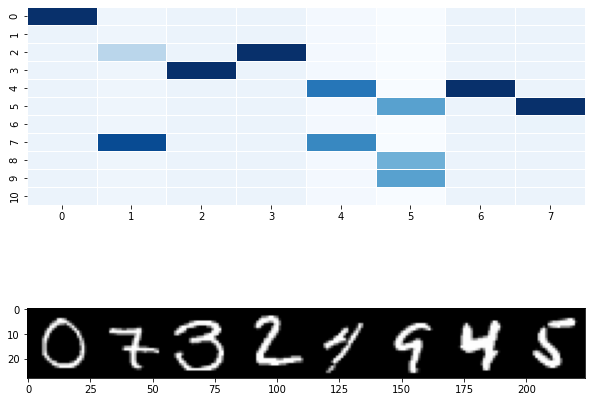

In [29]:
pred_eval_plot(sample_output[0, ...].numpy().T, test_image.numpy().T)

---